In [ ]:
%pip install ffmpeg

In [1]:
import pandas as pd
import gc #gc.collect()
import numpy as np
import torch
from torch.utils.data import DataLoader
from torch import nn
import torch.nn.functional as F
from torchvision import transforms
#import torchaudio
#from torchaudio import transforms
import librosa
import librosa.display
from datasets import Dataset
from collections import Counter
from pathlib import Path
#import torchaudio
import matplotlib.pyplot as plt
import os
from torch.utils.data import Dataset
from itertools import chain
from PIL import Image

# Read csv files

In [2]:
df_birds = pd.read_csv(f"archive_birds\Birds Voice.csv")
df_birds

,common_name,scientific_name,recordist_name,recording_length,Date,TYPE,xc_id,Time,Country,Download_link
0,Common Ostrich,Struthio camelus australis,Frank Lambert,0:53,2019-10-30,call,XC516153,08:05,South Africa,https://xeno-canto.org/516153/download
1,Common Ostrich,Struthio camelus,Jeremy Hegge,0:26,2014-11-20,call,XC208209,04:00,South Africa,https://xeno-canto.org/208209/download
2,Common Ostrich,Struthio camelus,Jeremy Hegge,0:04,2014-11-21,call,XC208128,06:00,South Africa,https://xeno-canto.org/208128/download
3,Common Ostrich,Struthio camelus,Derek Solomon,0:11,2010-02-09,call,XC46725,07:00,South Africa,https://xeno-canto.org/46725/download
4,Common Ostrich,Struthio camelus,Morioka Zoological Park ZOOMO,1:47,2021-09-06,"voice during egg laying, zoo collection",XC675445,17:00,Japan,https://xeno-canto.org/675445/download
...,...,...,...,...,...,...,...,...,...,...
2156,Black-fronted Piping Guan,Pipile jacutinga,Peter Boesman,0:06,2004-08-06,song,XC228155,05:45,Brazil,https://xeno-canto.org/228155/download
2157,Black-fronted Piping Guan,Pipile jacutinga,Robson Silva e Silva,0:02,2012-09-19,wing sounds,XC110142,08:05,Brazil,https://xeno-canto.org/110142/download
2158,Black-fronted Piping Guan,Pipile jacutinga,Robson Silva e Silva,0:04,2012-09-19,song,XC110141,08:05,Brazil,https://xeno-canto.org/110141/download
2159,Black-fronted Piping Guan,Pipile jacutinga,Jeremy Minns,0:05,2003-10-08,wing sounds while displaying,XC85349,06:44,Brazil,https://xeno-canto.org/85349/download


# Pick serveral species

In [3]:
bird_counts = df_birds['common_name'].value_counts(ascending=False)
class_num = 15
top_birds = bird_counts.head(class_num).index

print(top_birds)


Index(['Plain Chachalaca', 'Andean Guan', 'Red-legged Tinamou',
       'Yellow-legged Tinamou', 'Black-capped Tinamou', 'Thicket Tinamou',
       'Variegated Tinamou', 'Orange-footed Scrubfowl', 'Bartlett's Tinamou',
       'Small-billed Tinamou', 'Rusty-margined Guan', 'Tataupa Tinamou',
       'Red-winged Tinamou', 'Andean Tinamou', 'Brazilian Tinamou'],
      dtype='object', name='common_name')


# Add filepaths to DataFrame

In [4]:
def load_data(filepath, bird_name):
    file_list = []
    sample_list = []
    for file in Path('archive_birds/').glob(filepath):
        sample_name = file.stem + '.wav'
        file_list.append(file)
        sample_list.append(str(sample_name))
    dd = pd.DataFrame()
    dd['file'] = file_list
    dd['FileName'] = sample_list
    dd['Class'] = bird_name # .csv doesn't contain class
    return dd

In [5]:
# Collect filepaths for train data.
data_list = []
for i in top_birds:
    dd_train = load_data(f'Voice of Birds/Voice of Birds/{i}_sound/*.mp3', i)
    data_list.append(dd_train)
file_df = pd.concat(data_list, ignore_index=True)
file_df

,file,FileName,Class
0,archive_birds\Voice of Birds\Voice of Birds\Pl...,Plain Chachalaca10.wav,Plain Chachalaca
1,archive_birds\Voice of Birds\Voice of Birds\Pl...,Plain Chachalaca11.wav,Plain Chachalaca
2,archive_birds\Voice of Birds\Voice of Birds\Pl...,Plain Chachalaca12.wav,Plain Chachalaca
3,archive_birds\Voice of Birds\Voice of Birds\Pl...,Plain Chachalaca13.wav,Plain Chachalaca
4,archive_birds\Voice of Birds\Voice of Birds\Pl...,Plain Chachalaca14.wav,Plain Chachalaca
...,...,...,...
415,archive_birds\Voice of Birds\Voice of Birds\Br...,Brazilian Tinamou5.wav,Brazilian Tinamou
416,archive_birds\Voice of Birds\Voice of Birds\Br...,Brazilian Tinamou6.wav,Brazilian Tinamou
417,archive_birds\Voice of Birds\Voice of Birds\Br...,Brazilian Tinamou7.wav,Brazilian Tinamou
418,archive_birds\Voice of Birds\Voice of Birds\Br...,Brazilian Tinamou8.wav,Brazilian Tinamou


# Saving images

In [6]:
def split_data(df):
    classlist = []
    for bird in top_birds:
        dd_temp = df[df['Class'] == bird]
        classlist.append(dd_temp)
    return classlist

# Shuffle training data (to separate better into validation-training parts).
dd_total = file_df.sample(frac=1).reset_index(drop=True)

# Make part of the training data training data (~70%)
dd_train = pd.DataFrame(columns=dd_total.columns)
rows = dd_total[ : file_df.shape[0] * 7 // 10]
dd_train = pd.concat([dd_train, rows], ignore_index=True)
dd_total.drop(rows.index, inplace=True)

# Make part of the training data validation data (~20%)
dd_val = pd.DataFrame(columns=dd_total.columns)
rows = dd_total[ : file_df.shape[0] * 2 // 10]
dd_val = pd.concat([dd_val, rows], ignore_index=True)
dd_total.drop(rows.index, inplace=True)

# Make part of the training data test data (~10%)
dd_test = pd.DataFrame(columns=dd_total.columns)
rows = dd_total[ : file_df.shape[0] * 1 // 10]
dd_test = pd.concat([dd_test, rows], ignore_index=True)
dd_total.drop(rows.index, inplace=True)

# Create lists of data for each type (test, val, train) with each class.
class_list_train = split_data(dd_train)
class_list_val = split_data(dd_val)
class_list_test = split_data(dd_test)

folder_names = top_birds

In [36]:
def save_mel_images(folder_name, folder_names, class_list):

    if not os.path.exists(folder_name):
           os.makedirs(folder_name)
    if not os.path.exists(folder_name + '/birds'):
           os.makedirs(folder_name + '/birds')

    for i, category in enumerate(folder_names):
        for j, file in enumerate(class_list[i]['file']):
            y, sr = librosa.load(file)
            plt.axis('off') # no axis
            plt.axes([0., 0., 1., 1.], frameon=False, xticks=[], yticks=[]) # Remove the white edge
    
            S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=512)
            librosa.display.specshow(librosa.power_to_db(S, ref=np.max))
            plt.savefig(folder_name + '/birds/'+'/mel{}{}'.format(folder_names[i], j)+'.jpg')
            plt.close()

        
save_mel_images('trainFFT512', folder_names, class_list_train)
save_mel_images('testFFT512', folder_names, class_list_test)
save_mel_images('valFFT512', folder_names, class_list_val)

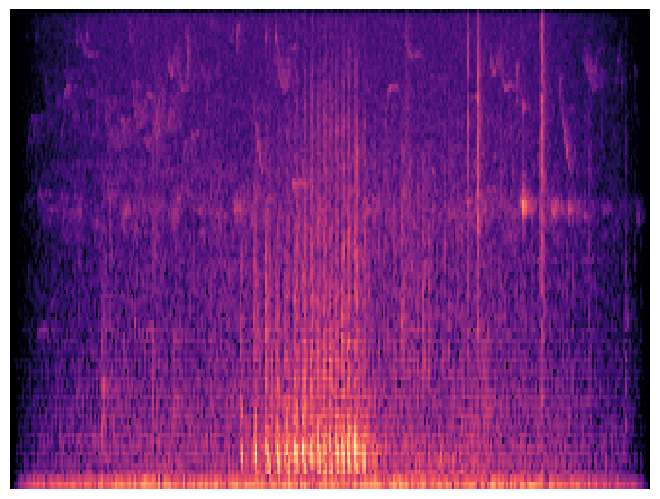

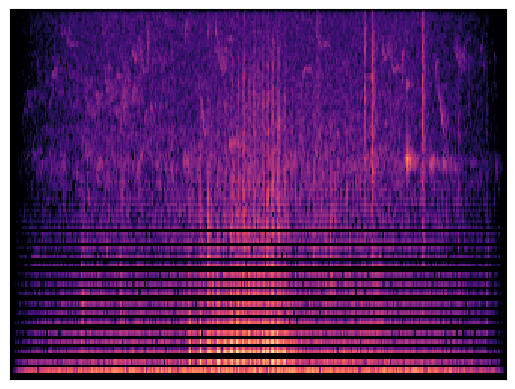

In [38]:
y, sr = librosa.load('archive_birds/Voice of Birds/Voice of Birds/Andean Guan_sound/Andean Guan10.mp3')
plt.axis('off') # no axis
plt.axes([0., 0., 1., 1.], frameon=False, xticks=[], yticks=[]) # Remove the white edge
    
S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=512)
librosa.display.specshow(librosa.power_to_db(S, ref=np.max))
plt.show()
S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=256)
librosa.display.specshow(librosa.power_to_db(S, ref=np.max))